In [5]:
# Install the library we need for the notebook
!pip3 install --user 'implicit'

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Building a music recommender system (Spring 2019)

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Pandas, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing an algorithm like Matrix Factorization
* Finally, we will focus on an existing implementation, available in ```Implicit```, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for scrobbling, or recording listeners' plays of artists' songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users' plays of artists' are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import implicit

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from time import time

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit

base = "/mnt/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)

Using Pandas, load data from `/datasets/lastfm/user_artist_data.txt` (407 MB) and show the first 20 entries (via function `show()`).

```bash 
$ du -sh /mnt/datasets/lastfm/user_artist_data.txt
407M     /mnt/datasets/lastfm/user_artist_data.txt
```

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".


In [2]:
# Read the .csv file (might take a while).
userArtistDF = pd.read_csv(base + 'user_artist_data.txt', 
                           sep=' ', 
                           header=None, 
                           names=['userID', 'artistID', 'playCount'])

# Cast each column to its correct datatype.
userArtistDF['userID'] = userArtistDF['userID'].astype(np.int64, errors='ignore')
userArtistDF['artistID'] = userArtistDF['artistID'].astype(np.int64, errors='ignore')
userArtistDF['playCount'] = userArtistDF['playCount'].astype(np.int32, errors='ignore')

# Display 5 first elements.
userArtistDF[:5]

,userID,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314


#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [3]:
# Count unique number of instances on key 'userID'
uniqueUsers = userArtistDF['userID'].nunique()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [4]:
# Count unique number of instences on key 'artistID'
uniqueArtists = userArtistDF['artistID'].nunique()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. 

One thing we can see here is that Pandas provides very concise and powerful methods for data analytics.

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [4]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupby('userID', as_index = False).playCount.sum()
print(userActivity[0:5])

   userID  playCount
0      90        537
1      98        186
2     116         20
3     120         65
4     128        133


#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (10%, 25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

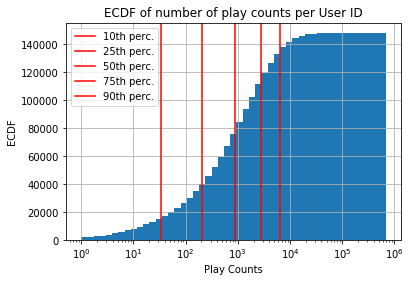

In [5]:
fig, ax = plt.subplots()

number_of_bins = 50
minBin = userActivity['playCount'].min()
maxBin = userActivity['playCount'].max()
binspacing = np.logspace(np.log10(minBin),np.log10(maxBin), number_of_bins)

# Plot the cumulative distribution
userActivity['playCount'].hist(cumulative = True, bins=binspacing, ax=ax)

# Calculate and plot the 5 important percentiles
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax.axvline(userActivity['playCount'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = 'red')
    
ax.semilogx()
ax.set_title('ECDF of number of play counts per User ID')
ax.set_xlabel('Play Counts')
ax.set_ylabel('ECDF')
ax.legend()
plt.show()

#### Answer 2.2: 
<div class="alert alert-success">
The histogram shows that about 25% of users has less than 200 plays, which is not a lot compared to the top 10% which has more than 6000 plays each, and some even more than 100000. It is thus fair to assume that the recommendation for these users will not be as good as for the more active users. From a human point of view, looking at just 200 plays or less it might be hard to decide on what kind of taste in music the person has and thus difficult to make good recommendations. From a statistical point of view, with so few plays one can argue that the dataset is noisy compared to the active users. Thus, when measuring the performance of the recommender system it is likely that the group of users with few plays will drag the overall performance down. 

At the other end of the scale we have 10% of the users having more than 6000 plays. The dataset of these users will help the recommender system to find good references and correlations between artists improving the recommender performance. However, making good recommendations to these top users might be hard. This is because with so many plays the users are more likely to have already discovered the artists that the recommender system otherwise would recommend.

Overall the histogram looks reasonable as we know the total amount of users are 148111, which also seems to be the height of the last bin.
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

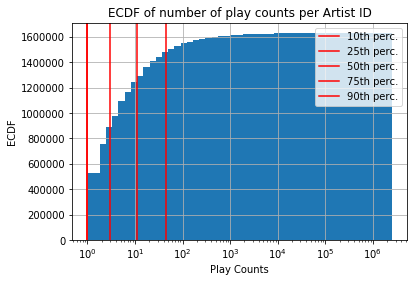

In [6]:
# Compute artist popularity
# We are interested in how many playcounts per artist

artistPopularity = userArtistDF.groupby('artistID', as_index = False).playCount.sum()

fig, ax = plt.subplots()

number_of_bins = 50
minBin = artistPopularity['playCount'].min()
maxBin = artistPopularity['playCount'].max()
binspacing = np.logspace(np.log10(minBin),np.log10(maxBin), 50)

artistPopularity['playCount'].hist(cumulative = True, bins=binspacing, ax=ax)

# Calculate and plot the 5 important percentiles
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax.axvline(artistPopularity['playCount'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color='red')

ax.semilogx()
ax.set_title('ECDF of number of play counts per Artist ID')
ax.set_xlabel('Play Counts')
ax.set_ylabel('ECDF')
ax.legend(loc=1)
plt.show()


#### Answer 2.3: 
<div class="alert alert-success">
The histogram increases rapidly, meaning there are a few artist accounting for most of the plays. In fact, we see that 75% of the artist only have 10 plays or less. With 148000 users, 10 plays is nothing. However, it is not surprising that a few 'pop' artists accounts for the majority of the play counts and thus the histogram looks reasonable.

This means that there is very little data on majority of the artists, and thus we might expect that the recommender system will prefer recommending more popular artists.
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 10 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-10 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

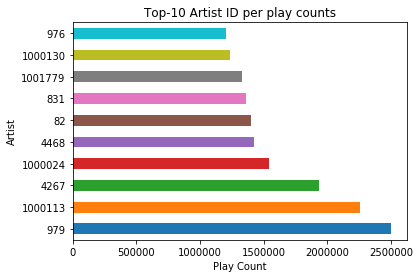

In [7]:
topN = 10
topNArtist = artistPopularity.sort_values('playCount', ascending=False)[:topN]

fig, ax = plt.subplots()

topNArtist.plot(x='artistID',
                y='playCount', 
                kind='barh', 
                legend=False, 
                title='Top-10 Artist ID per play counts',
                ax=ax)

ax.set_xlabel('Play Count') 
ax.set_ylabel('Artist')     

plt.show()

#### Answer 2.4:
<div class="alert alert-success">
The chart seems reasonable with not too many play counts seperating the artists. The play counts of the top ten artists is in agreement with the histogram in question 2.3, in as much as that there are few artists that account for most of the play counts.  
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data ('\t'-separated) from `/datasets/lastfm/artist_data.txt` and use the Pandas API to show 5 samples.  
</div>

**HINT**: `artist_data.txt` has malformed entries. If you encounter some error when parsing lines in data because of invalid entries, functions `pandas.DataFrame.dropna()` and `pandas.to_numeric()` will help you to eliminate these entries.


In [8]:
# Read from the .csv file
artistDF = pd.read_csv(base + 'artist_data.txt',
                       sep='\t',
                       header=None,
                       names=['artistID', 'name'])


# Filter out possible malformed entries
artistDF.artistID = pd.to_numeric(artistDF.artistID, errors = 'coerce')
artistDF = artistDF.dropna()

# Cast each column to its datatype
artistDF.artistID = artistDF.artistID.astype(np.int64)
artistDF.name = artistDF.name.astype(str, errors = 'raise')

# Display 5 elements.
artistDF[3670:3675]



/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,artistID,name
3670,10024022,デューク・エリントン楽団
3671,10024023,Alas - 04 - Absolute Purity
3672,10024024,Piero Barbetti
3673,10024025,The James Taylot Quartet
3674,10024026,spice_girls


#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  
</div>

**HINT**: Function `contains(string)` can be useful in this case.

In [9]:
# get artists whose name contains "Aerosmith"
print(artistDF[artistDF.name.str.contains('Aerosmith')][:20])


# show two examples
print(artistDF[artistDF['artistID'] == 1000010])
print(artistDF[artistDF['artistID'] == 2082323])

       artistID                                            name
9925   10586006                     Dusty Springfield/Aerosmith
12010   6946007                                Aerosmith/RunDMC
12456  10475683                       Aerosmith: Just Push Play
14567   1083031                                Aerosmith/ G n R
15761   6872848  Britney, Nsync, Nelly, Aerosmith,Mary J Blige.
19409  10586963          Green Day - Oasis - Eminem - Aerosmith
20337  10028830                         The Aerosmith Antology2
25166  10300357                             Run-DMC + Aerosmith
26399   2027746                     Aerosmith by MusicInter.com
28469   1140418                      [rap]Run DMC and Aerosmith
30207  10237208                             Aerosmith + Run DMC
33127  10588537                  Aerosmith, Kid Rock, & Run DMC
41891   9934757                            Aerosmith - Big Ones
42294  10437510                 Green Day ft. Oasis & Aerosmith
48005   6936680                         

#### Answer  3.2:
<div class="alert alert-success">
There are many instances of the same artist name mainly because of collaborations, i.e. multiple artists are credited on the same song.
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using Pandas, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [10]:
# Read file
artistAliasDF = pd.read_csv(base + 'artist_alias.txt',
                            sep='\t',
                            header=None,
                            names=['misspelledArtistID', 'standardArtistID'])

# Filter and cast to from string to numerical datatype.
artistDF.artistID = pd.to_numeric(artistDF.artistID, errors = 'coerce')
artistAliasDF = artistAliasDF.dropna()
artistAliasDF.misspelledArtistID = artistAliasDF.misspelledArtistID.astype(np.int64)

# Display 5 first elements
artistAliasDF[:5]



,misspelledArtistID,standardArtistID
0,1092764,1000311
1,1095122,1000557
2,6708070,1007267
3,10088054,1042317
4,1195917,1042317


#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [14]:
print(artistAliasDF[artistAliasDF.misspelledArtistID == 2082323])

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset

      misspelledArtistID  standardArtistID
1135             2082323           1000010


#### Answer 3.4:
<div class="alert alert-success">
Yes, artist ID 2082323 are indeed listed as mispelled with the true ID being 1000010.
</div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.

#### Question 4.2
<div class="alert alert-info">
Replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.

**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem and find a way to fix the duplicates (user, artist).

**HINT**: have a look to the functions `pandas.merge()` and `pandas.Dataframe.combine_first()`.

In [13]:
t0 = time()

# Join the two dataframes based on the misspelledArtistID
newUserArtistDF = pd.merge(userArtistDF, artistAliasDF, left_on='artistID', right_on='misspelledArtistID', how='left')

# Get the final realArtistID
newUserArtistDF['realArtistID'] = newUserArtistDF['standardArtistID'].combine_first(newUserArtistDF['artistID']).astype(np.int64)

# Delete columns not required
newUserArtistDF.drop(['artistID', 'standardArtistID', 'misspelledArtistID'], axis=1, inplace=True)

# Fix duplicates of the pair (userID, realArtistID)
newUserArtistDF = newUserArtistDF.groupby(['realArtistID', 'userID'], as_index=False).playCount.sum()

print('Cleaning the dataset took %.2f seconds' % (time() - t0))

# Display 5 first elements
newUserArtistDF[:5]

Cleaning the dataset took 32.81 seconds


,realArtistID,userID,playCount
0,1,803,7
1,1,3048,1
2,1,3165,11
3,1,3332,57
4,1,3921,2


In [16]:
assert (newUserArtistDF.groupby(['userID', 'realArtistID'], as_index=False).count()['playCount'] == 1).all(),  \
    'Each combination user/artist should appear only once'

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries. Now that we have all data, including the relation (`artistID`/`name`), please find a way to use the artist name instead of its ID in all required plots.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [12]:
uniqueArtists = newUserArtistDF['realArtistID'].nunique()

print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1568126


#### Answer 5.1:
<div class="alert alert-success">
The number of artists has now been reduced to 1568126 from the previous 1631028. In other words there were 62902 duplicates that has now been removed.
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

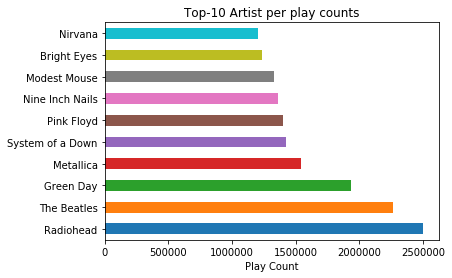

In [18]:
# calculate top-10 artists in term of play counts
topN = 10

artistPopularity = newUserArtistDF.groupby('realArtistID', as_index=False).playCount.sum()

# Get the name of the artists based on their IDs
artistPopularity = pd.merge(artistPopularity, artistDF, 
                            left_on='realArtistID', right_on='artistID' , how='inner')

topNArtist = artistPopularity.sort_values('playCount', ascending=False)[:topN]

# Plot
fig, ax = plt.subplots()
topNArtist['playCount'].plot(kind='barh', ax=ax)
ax.set_yticklabels(topNArtist['name'])
ax.set_xlabel('Play Count')
ax.set_title('Top-10 Artist per play counts')

plt.show()


#### Answer 5.2.1:
<div class="alert alert-success">
This top 10 chart has not changed much from the initial one, though now we are able to map the artist names to the artist ID making the chart more meaningful. The top 10 names are indeed familar.
</div>

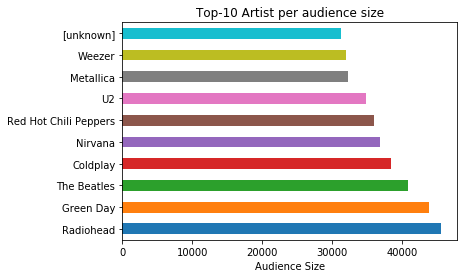

In [19]:
topN = 10

# Should really use nunique, but doesnt work.. but in this case it is the same.
artistAudience = newUserArtistDF.groupby('realArtistID', as_index=False).userID.count()
# Rename for clarity. Column userID after grouping represents audience size.
artistAudience.rename(columns={'userID':'audienceSize'}, inplace=True)

# Merge to get artist names.
artistAudience = pd.merge(artistAudience, artistDF, left_on='realArtistID', right_on='artistID', how='inner')
# Extract topN artist with biggest audience.
topNArtist = artistAudience.sort_values('audienceSize', ascending=False)[:topN]

fig, ax = plt.subplots()

topNArtist['audienceSize'].plot(kind='barh', ax=ax)

ax.set_yticklabels(topNArtist['name'])
ax.set_xlabel('Audience Size')
ax.set_title('Top-10 Artist per audience size')

plt.show()


#### Answer 5.1.2:
<div class="alert alert-success">
This chart do not care about absolute play count, but simply how many unique listeners each artist have. This chart is more even with even less difference between each artist.
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

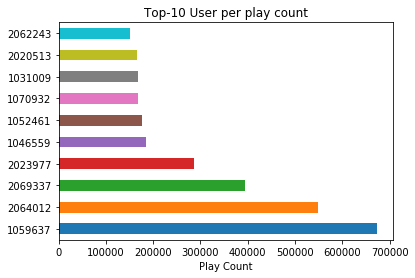

In [20]:
# calculate top-10 user in term of play counts
topN = 10

userPlayCount = newUserArtistDF.groupby('userID', as_index=False).sum()
topNUser = userPlayCount.sort_values('playCount', ascending = False)[:topN]

fig, ax = plt.subplots()

topNUser['playCount'].plot(kind='barh', ax=ax)

ax.set_yticklabels(topNUser['userID'])
ax.set_xlabel('Play Count')
ax.set_title('Top-10 User per play count')

plt.show()


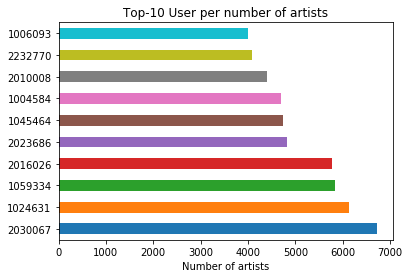

In [21]:
# calculate top-10 user in term of curiosity
topN = 10

userCuriosity = newUserArtistDF.groupby('userID', as_index=False).realArtistID.count()
userCuriosity.rename(columns={'realArtistID':'nuniqueArtists'}, inplace=True)
topNUser = userCuriosity.sort_values('nuniqueArtists', ascending = False)[:topN]

fig, ax = plt.subplots()

topNUser['nuniqueArtists'].plot(kind='barh', ax=ax)

ax.set_yticklabels(topNUser['userID'])
ax.set_xlabel('Number of artists')
ax.set_title('Top-10 User per number of artists')

plt.show()


Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| .  | IT1 | IT2 | IT3 | ... | ITk |
|----|---|---|---|---|---|
| U1 | 1 | na | 5 | ... | 3 |
| U2 | na | 2 | na | ... | 2 |
| U3 | 5 | na | 3 | ... | na |
| U4 | 3 | 3 | na | ... | 4 |
| U5 | na | 1 | na | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly.

From these requirement, we can choose using ALS algorithm in [Implicit](https://implicit.readthedocs.io/en/latest/).

### Question 6

The library choosen for implementing ALS has a strict requirement in terms of data format. In particular `userID` and `artistID` should be both incremetally assigned starting from 0 (e.g. the first valid `userID` is 90 and it has to correspond to 0). In these next questions we will try to fix this issue.

#### Question 6.1

<div class="alert alert-info">
Create a table with incremental ID for artists and print the first 15 entries.
</div>

In [37]:
artistMappingDF = pd.DataFrame()
artistMappingDF['originalArtistID']  = newUserArtistDF.sort_values('realArtistID').realArtistID.unique() # Get all 'originalArtistID' values, but no duplicates
artistMappingDF['incrementalArtistID'] = artistMappingDF.index

# Display first 15 elements.
artistMappingDF[:15]

,originalArtistID,incrementalArtistID
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
5,6,5
6,7,6
7,8,7
8,9,8
9,11,9


#### Question 6.2 

<div class="alert alert-info">
Create a table with incremental ID for users and print the first 15 entries.
</div>

In [38]:
userMappingDF = pd.DataFrame()
userMappingDF['originalUserID'] = newUserArtistDF.sort_values('userID').userID.unique()
userMappingDF['incrementalUserID'] = userMappingDF.index

# Display first 15 elements.
userMappingDF[:15]

,originalUserID,incrementalUserID
0,90,0
1,98,1
2,116,2
3,120,3
4,128,4
5,139,5
6,277,6
7,321,7
8,340,8
9,350,9


#### Question 6.3 

<div class="alert alert-info">
Starting from the clean dataset that we already have, find a way to replace the original IDs with the new ones. Print the first 15 entries in this new table.
</div>

In [39]:
rescaledUserArtistDF = pd.merge(newUserArtistDF, artistMappingDF, 
                                left_on = 'realArtistID', 
                                right_on = 'originalArtistID').drop(['realArtistID', 'originalArtistID'], axis=1)

rescaledUserArtistDF = pd.merge(rescaledUserArtistDF, userMappingDF, 
                                left_on = 'userID',
                                right_on = 'originalUserID').drop(['userID', 'originalUserID'], axis=1)
# Display first 15 elements.
rescaledUserArtistDF[:15]

,playCount,incrementalArtistID,incrementalUserID
0,7,0,24
1,10,1,24
2,1,12,24
3,2,45,24
4,2,47,24
5,5,54,24
6,1,63,24
7,28,66,24
8,1,68,24
9,17,80,24


Now, we don't need no more `userArtistDF` and `newUserArtistDF`. We can delete them and free some memory

In [50]:
del userArtistDF
del newUserArtistDF

## 3.4 Training our statistical model
To train a model using ALS, we must use a sparse matrix as an input. Implicit uses the class sparse matrix to support the construction of a distributed preference matrix.

### Question 7

The implicit library expects data as a item-user sparse matrix. Now we create two matricies, one for fitting the model (item-user) and one for recommendations (the transpose of item-user -- user-item).

In [27]:
import scipy.sparse as sparse
import implicit

def to_sparse(userArtistDF):
    playCount = userArtistDF['playCount'].astype(float)
    artistID = userArtistDF['incrementalArtistID']
    userID = userArtistDF['incrementalUserID']
    sparse_item_user = sparse.csr_matrix((playCount, (artistID, userID)))

    return sparse_item_user

sparse_item_user = to_sparse(rescaledUserArtistDF)
sparse_user_item = sparse_item_user.T # Transpose

#### Question 7.1
<div class="alert alert-info">
Train a model trained by using `implicit.als.AlternatingLeastSquares()`.
</div>

Read **carefully** the documentation of this class.

We can also use some additional parameters to adjust the quality of the model. For now, let's set 

- `factors = 10`
- `iterations = 5`
- `regularization = 0.01`
- `alpha = 1.0`

to build the model.

In [28]:
factors = 10
iterations = 5
regularization = 0.01
alpha = 1.0

# Calculate the confidence matrix by multiplying the item/user matrix by our alpha value.
data_conf = (sparse_item_user * alpha).astype('double')

# Create the model
model = implicit.als.AlternatingLeastSquares(factors = factors, regularization = regularization, iterations = iterations)
#Fit the model
model.fit(data_conf)

100%|██████████| 5.0/5 [01:09<00:00, 15.03s/it]


#### Question 7.5
<div class="alert alert-info">
Print the user features for the first user
</div>

In [29]:
print(model.user_factors[:1])

[[-0.26660407  0.08868402 -0.07620859  0.16080274 -0.0135186   0.16315183
  -0.13881786  0.34277657 -0.02223734  0.06919209]]


### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try also with different users!).
</div>

**HINT**: The recommendations can be given by function `recommend()`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`. Remember that we have transformed our IDs, so what you need to do is `userID -> incrementalUserID -> recommend() -> incrementalArtistID -> artistID -> name`

In [30]:
# Retrieve the incrementalUserID from a userID
def get_incrementalUserID(userID):
    return int(userMappingDF.loc[userMappingDF.originalUserID == userID].incrementalUserID)

# Retrieve the original userID from an incrementalUserID
def get_userID(incrementalUserID):
    return userMappingDF.loc[userMappingDF.incrementalUserID == incrementalUserID].originalUserID.values[0]

# Retrieve the incrementalArtistID from an artistID
def get_incrementalArtistID(artistID):
    return artistMappingDF.loc[artistMappingDF.originalArtistID == artistID].incrementalArtistID.values[0]

# Retrieve the original artistID from an incrementalArtistID
def get_artistID(incrementalArtistID):
    return artistMappingDF.loc[artistMappingDF.incrementalArtistID == incrementalArtistID].originalArtistID.values[0]

# Retrive the artist name
def get_artist_name(artistID):
    return artistDF.loc[artistDF.artistID == artistID].name.values[0]

# Retrive the recommendations
def printRecArt(originaluserID):
    recommendations = model.recommend(get_incrementalUserID(originaluserID), sparse_item_user)
    artists = []
    scores = []
    for items in recommendations:
        incremental_artist_ID, score = items
        artists.append(get_artist_name(get_artistID(incremental_artist_ID)))
        scores.append(score)
    pR = pd.DataFrame({'Artist': artists, 'Score': scores})
    return pR

# Print the recommended artists
test_user_id = 2093760
user_biggest_artist_repartoire = 2030067
user_highest_play_count = 1059637

print('Reccomendations for test user ID: \n', printRecArt(test_user_id), '\n')
print('Reccomendations for user with biggest artist repartoire: \n', printRecArt(user_biggest_artist_repartoire), '\n')
print('Reccomendations for user with highest play_count: \n', printRecArt(user_highest_play_count), '\n')


Reccomendations for test user ID: 
              Artist     Score
0          The Game  0.025371
1        Kanye West  0.024663
2           50 Cent  0.024434
3               Nas  0.024112
4             Jay-Z  0.024061
5              2Pac  0.024012
6          Ludacris  0.023789
7        Snoop Dogg  0.023690
8  Notorious B.I.G.  0.023406
9           Dr. Dre  0.023294 

Reccomendations for user with biggest artist repartoire: 
          Artist     Score
0          ABBA  1.532247
1          Toto  1.509625
2          a-ha  1.498520
3   Diana Krall  1.477169
4       Roxette  1.472675
5      Bee Gees  1.462285
6          Seal  1.461951
7     The Corrs  1.455107
8          P!nk  1.439831
9  Phil Collins  1.437688 

Reccomendations for user with highest play_count: 
               Artist      Score
0          Nightwish  13.917391
1      Dream Theater  13.387062
2        Iron Maiden  13.275727
3     Sonata Arctica  13.138988
4              Opeth  12.983013
5          In Flames  12.885807
6  Within

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

***Hint***: have a look to `train_test_split()` in `sklearn.model_selection`

In [31]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# Create train/test split
trainUserArtistDF, testUserArtistDF = train_test_split(rescaledUserArtistDF, 
                                                       train_size = 0.9, 
                                                       test_size = 0.1)

# Transform to sparse matrix
train_sparse_item_user = to_sparse(trainUserArtistDF)
train_sparse_user_item = train_sparse_item_user.T

# Compute the confidence matrix
data_conf = (train_sparse_item_user * alpha).astype('double')

# Create the model
model = implicit.als.AlternatingLeastSquares(factors = factors, regularization = regularization, iterations = iterations)

# Train
model.fit(data_conf)

100%|██████████| 5.0/5 [01:04<00:00, 14.08s/it]


#### Area under the ROC curve: a function to compute it

In [32]:
from multiprocessing import Pool
import warnings
from sklearn.metrics import roc_auc_score
import random
from tqdm import tqdm


def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1

def _compute_auc(incremental_user_id):
    positive_products = testUserArtistDF[testUserArtistDF['incrementalUserID'] == incremental_user_id]['incrementalArtistID'].values
    positive_ranking = model.rank_items(incremental_user_id, 
                                        train_sparse_user_item, 
                                        positive_products)
    positive_ranking = list(map(lambda x: x[1], positive_ranking))
    if len(positive_products) <= 1: return 
        
    train_data_user = trainUserArtistDF[trainUserArtistDF['incrementalUserID'] == incremental_user_id]['incrementalArtistID'].values
    
    if len(train_data_user) < 1: return
    negative_products = np.random.choice(train_data_user, len(positive_products))  
    if len(negative_products) <= 1: return
        
    if len(negative_products) != len(positive_products): return 
    
    negative_ranking = model.rank_items(incremental_user_id, 
                                        train_sparse_user_item, 
                                        negative_products)
    
    negative_ranking = list(map(lambda x: x[1], negative_ranking))
   
    correct = 0
    total = len(positive_ranking)*len(negative_ranking)

    for positive in positive_ranking:
        correct += findNumElementsSmallerThan(negative_ranking, positive)
    return float(correct) / total

def compute_auc(test_users_ratio=1, parallelism=4):  
    """
        Computes the AUC of a train/test split
        Note:
            It assumes `trainUserArtistDF`, `testUserArtistDf` and `model` to be defined 
            globally
        Arguments:
            test_users_ratio (float): Ratio of users to be tested (0, 1]
    """
    if test_users_ratio <=0 or test_users_ratio > 1:
        warnings.warn('Parameter test_users_ratio has to be in (0, 1]. Setting test_users_ratio=1...')
        test_users_ratio = 1
    
    pool = Pool(parallelism)
    roc_auc = []
    list_of_users = testUserArtistDF['incrementalUserID'].unique()[::int(1/test_users_ratio)]
    for res in tqdm(pool.imap_unordered(_compute_auc, list_of_users, 64), total=len(list_of_users)):
        roc_auc.append(res)
    
    pool.close()
    pool.join()

    return np.array(list(filter(None.__ne__, roc_auc)))

####  Question 9.2
<div class="alert alert-info">
Using `compute_auc()`, compute the AUC of the trained model.
</div>

***Note***: `compute_auc()` is computational expensive. To test if everything works, try to first compute the AUC for a small subset of users (10%) and than move to the entire set.

In [33]:
roc_auc = compute_auc(test_users_ratio = 1)
print('Average AUC = %.4f' % roc_auc.mean())

100%|██████████| 134608/134608 [22:10<00:00, 101.18it/s]


Average AUC = 0.8687


#### Question 9.3 

The average AUC doesn't give the full picture here. Try to plot the distribution and the cumulative distribution of the AUC for all the users. Can you comment on these plots? 

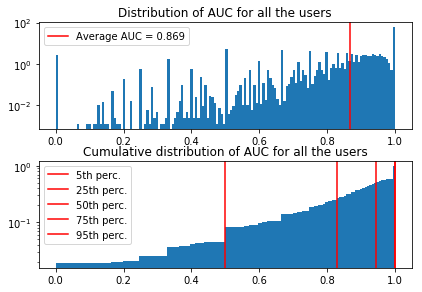

In [34]:
fig, (ax0, ax1) = plt.subplots(2,1)
fig.tight_layout()
# Plot distribution
ax0.hist(roc_auc, bins='auto', density=True, log=True) # Should add extra options here

# Plot cumulative distribution
ax1.hist(roc_auc, bins='auto', density=True, cumulative=True, log=True) # Should add extra options here

# Plot a vertical line on the average (distribution plot)
ax0.axvline(roc_auc.mean(), label='Average AUC = %.3f' % roc_auc.mean(), color = 'red')

# Plot some percentile on the cumulative distribution
for i, quantile in enumerate([.05, 0.25, .5, .75, .95]):
    ax1.axvline(np.percentile(roc_auc, quantile*100), label = '%.0fth perc.' % (quantile*100), color = 'red')

    
ax0.set_title('Distribution of AUC for all the users')
ax1.set_title('Cumulative distribution of AUC for all the users')
    
ax0.legend()
ax1.legend()
plt.show()

#### Answer 9.3:
<div class="alert alert-success">
We used a logarithmic scale on the y-axis to better illustrate the small bins compared to the high ones. From the first histogram showing the Distribution of AUC for all the users, the AUC-scores are on the x-axis and the amount of users that got one specific AUC-score on the y-axis. In the second histogram showing the Cumulative distribution of AUC for all users we see the AUC-score on the x-axis, and the total number of users that got this specific AUC-score or less on the y-axis. 

An AUC-score of 1 indicates that the reccomendation algorithm was able to reccomend all the artists in the test data and an AUC score of 0.5 is obtained by randomly reccomending artists. From the second histogram we can see that 5% of users had an AUC-score of 0.5 or below, and conversely 95% of users had an AUC-score of 0.5 and above. In addition, we can see that 75% of users experienced an AUC-score of approximately 0.82 and above, and 50% of users had an AUC score at approximately 0.95 and above.
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

***Hint***: have a look to `ParameterGrid()` in `sklearn.model_selection` 

In [ ]:
from sklearn.model_selection import ParameterGrid
# Define the hyperparameters
hyperparameters = {
    'factors': [10, 25, 50], 
    'regularization' : [0.0001, 1], 
    'alpha' : [1.0, 40]}

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))

# Just a table to save the results
resultsDF = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])
for parameter_combination in parameter_grid:
    factors = parameter_combination.get('factors')
    regularization = parameter_combination.get('regularization')
    alpha = parameter_combination.get('alpha')
    model = implicit.als.AlternatingLeastSquares(factors = factors, regularization = regularization, iterations = iterations)
    
    train_data_conf = (train_sparse_item_user * alpha).astype('double')

    model.fit(train_data_conf)
    
    auc = compute_auc(test_users_ratio = 0.1)
    
    parameter_combination['auc'] = auc.mean()
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
resultsDF.sort_values('auc')



  7%|▋         | 9153/134714 [01:29<15:01, 139.34it/s]
 10%|█         | 0.5/5 [00:03<00:31,  7.05s/it]
 20%|██        | 1.0/5 [00:24<01:08, 17.24s/it]
 30%|███       | 1.5/5 [00:28<00:50, 14.47s/it]

### Question 10.2

Sometimes an exhaustive search in the hyperparameter space is a waste of time and resources.
There are a lot of research questions open that deal with automating the end-to-end process of applying machine learning to real-world problems (e.g. **AutoML**).

Random sampling in the hyperparameter space is a possible -- very simple but yet quite powerfull -- technique.

Implement a simple parameter sampler and try a bunch of different configurations.

***Hint***: have a look to `ParameterSampler()` in `sklearn.model_selection` 

In [ ]:
import scipy.stats 
from sklearn.model_selection import ParameterSampler

# Hyperparameters are now definded by probability densities
hyperparameters = {
    'factors': scipy.stats.randint(10, 50), 
    'regularization' : scipy.stats.uniform(0.0001, 1.), 
    'alpha' : scipy.stats.uniform(1., 40.)}

parameter_grid = list(ParameterSampler(hyperparameters, n_iter = 6))

# You can either append the results to the previous table or create a new one
resultsDF_random = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])

for parameter_combination in parameter_grid:    

    factors = parameter_combination.get('factors')
    regularization = parameter_combination.get('regularization')
    alpha = parameter_combination.get('alpha')
    model = implicit.als.AlternatingLeastSquares(factors = factors,
                                                 regularization = regularization,
                                                 iterations = iterations)
    
    train_data_conf = (train_sparse_item_user * alpha).astype('double')

    model.fit(train_data_conf)
    
    auc = compute_auc(test_users_ratio = 0.1)
    
    parameter_combination['auc'] = auc.mean()
    resultsDF_random = resultsDF_random.append(parameter_combination, ignore_index=True)
    
resultsDF_random.sort_values('auc')

#### Question 10.3 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-10 artist names recommendated for user `2093760`.
</div>

In [40]:
factors = 12
regularization = 0.25
alpha = 4
model = implicit.als.AlternatingLeastSquares(factors = factors,
                                             regularization = regularization,
                                             iterations = 5)
                                             


data_conf = (sparse_item_user * alpha).astype('double')
model.fit(data_conf)

user_id = 2093760
print('Reccomendations for test user ', user_id, ': \n', printRecArt(test_user_id))

100%|██████████| 5.0/5 [01:50<00:00, 24.01s/it]


Reccomendations for test user  2093760 : 
             Artist     Score
0           Eminem  0.050715
1          50 Cent  0.050262
2          Dr. Dre  0.050066
3             2Pac  0.049279
4            Jay-Z  0.049110
5          Outkast  0.048694
6       Snoop Dogg  0.048485
7       Kanye West  0.047783
8  Black Eyed Peas  0.047236
9          N*E*R*D  0.047166


# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)